# Image Segmentation of a dog in a field

In [22]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv

import torch
from torchvision.transforms import functional as F
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
import numpy as np
from PIL import Image

import glob

## 1: Using OpenCV AdaptativeThreshold with divers enhancements


In [16]:
def showImg(img, title=''):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()
    

In [17]:
def detectDogInField(imgPath, showDetail=False):    
    img = cv.imread(imgPath)

    #Create a mask for grass
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    lowerGreen = np.array([35, 40, 40])
    upperGreen = np.array([85, 255, 255])

    grassMask = cv.inRange(hsv, lowerGreen, upperGreen)
    nonGrassMask = cv.bitwise_not(grassMask)
    if showDetail:
        showImg(nonGrassMask, "Non grass mask")

    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (15,15))
    maskClean = cv.morphologyEx(nonGrassMask, cv.MORPH_OPEN, kernel)
    maskClean = cv.morphologyEx(maskClean, cv.MORPH_CLOSE, kernel)
    if showDetail:
        showImg(maskClean, "Clean mask")

    #Create a mask for dog and combine it with the grass mask
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(16,16))
    grayCLAHE = clahe.apply(gray)


    dogMask = cv.adaptiveThreshold(grayCLAHE, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv.THRESH_BINARY_INV, 15, 4)

    combined_mask = cv.bitwise_and(maskClean, dogMask)

    if showDetail:
        showImg(grayCLAHE, "GrayCLAHE")
        showImg(dogMask, "Dog mask")
        showImg(combined_mask, "Combined mask")

    #Extract dog
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
    closing = cv.morphologyEx(combined_mask, cv.MORPH_CLOSE, kernel)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (4,4))
    opening = cv.morphologyEx(closing, cv.MORPH_OPEN, kernel)
    

    dilated = cv.dilate(opening, kernel, iterations=3)


    numLabels, labels, stats, _ = cv.connectedComponentsWithStats(dilated)
    filteredMask = np.zeros_like(dilated)
    for i in range(1, numLabels):  
        area = stats[i, cv.CC_STAT_AREA]
        if area > 5000:
            filteredMask[labels == i] = 255
            
    
    contours, hierarchy = cv.findContours(filteredMask, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    largest = max(contours, key=cv.contourArea)
    mask = np.zeros_like(gray)
    cv.drawContours(mask, [largest], -1, 255, thickness=cv.FILLED)
    

    if showDetail:
        showImg(closing, "Closing")
        showImg(opening, "Opening")
        showImg(dilated, "Dilated")
        showImg(filteredMask, "Filtered mask")
        showImg(mask, "Mask")


    numLabels, labels, stats, _ = cv.connectedComponentsWithStats(mask)
    finalMask = np.zeros_like(mask)
    maxArea = 0
    bestLabel = 0
    for i in range(1, numLabels):  # skip 0 (background)
        area = stats[i, cv.CC_STAT_AREA]
        if area > maxArea:
            maxArea = area
            bestLabel = i
    
    # Fill the final mask with the largest component
    finalMask[labels == bestLabel] = 255

    
                    
    if showDetail:
        showImg(mask, "Mask with holes filled")
        showImg(finalMask, "Final mask")
        
   

    overlay = img.copy()
    overlay[finalMask == 255] = (0, 0, 255)  # red where mask is white

    # Blend original image and red overlay
    blended = cv.addWeighted(img, 0.7, overlay, 0.3, 0)

    # Show result
    plt.imshow(cv.cvtColor(blended, cv.COLOR_BGR2RGB))
    plt.title("Red Mask Overlay")
    plt.axis("off")
    plt.show()


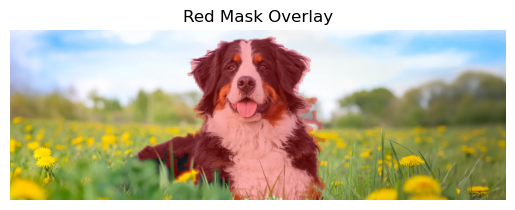

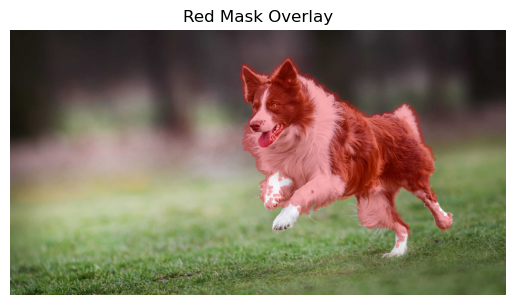

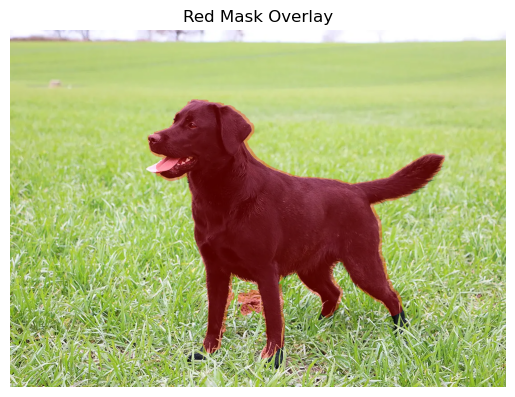

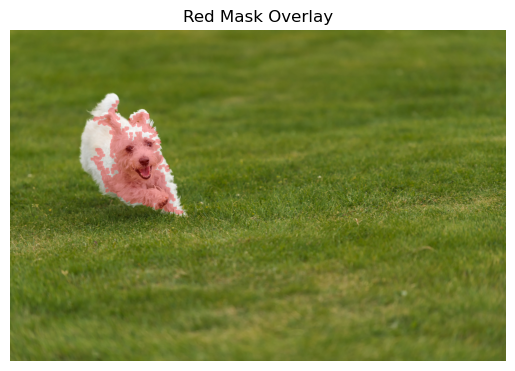

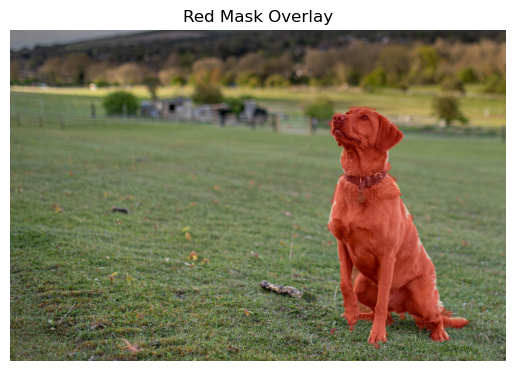

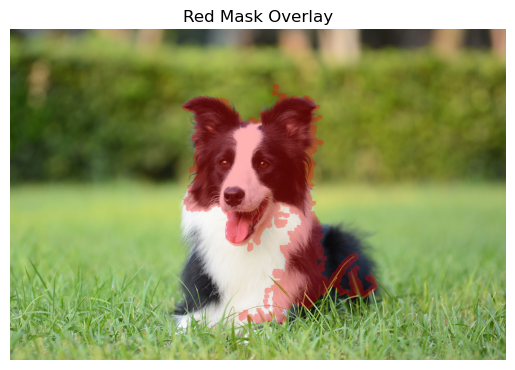

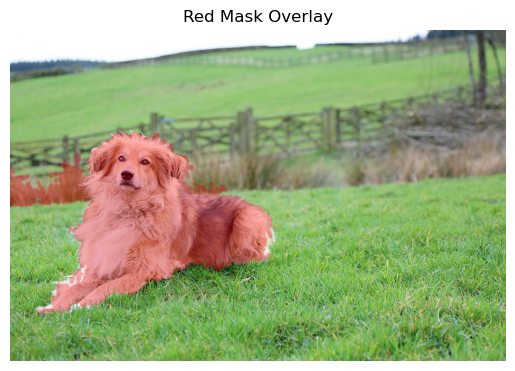

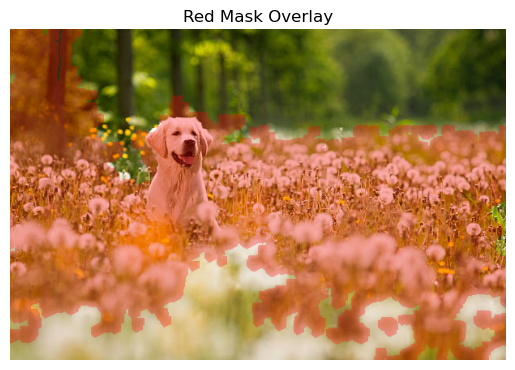

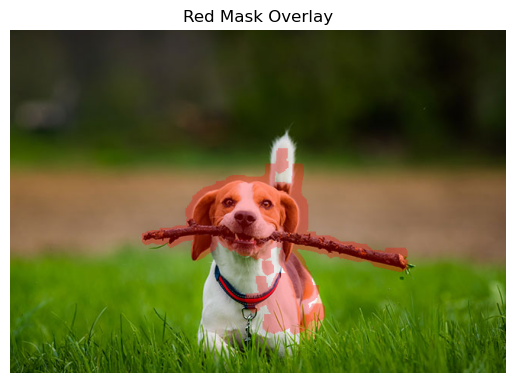

In [18]:
Detailed = False
dogImgNbr = 3

# List all .jpg and .png images in a folder
imagePaths = glob.glob("Img/*.jpg")
if(Detailed):
    detectDogInField(imagePaths[dogImgNbr], True)
else:
    for imgPath in imagePaths:
        detectDogInField(imgPath)

## 2: Using Pytorch with R-CNN model


In [19]:
# Load the pretrained Mask R-CNN model
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights)
model.eval()
 
# COCO class label for "dog"
dogClassId = 18

def loadImage(imgPath):
    img = Image.open(imgPath).convert("RGB")
    imgTensor = F.to_tensor(img)
    return img, imgTensor 

In [20]:
def detectDogInFieldTorch(imgPath, confThresh=0.7, showDetail=True):
    img, imgTensor = loadImage(imgPath)

    with torch.no_grad():
        output = model([imgTensor])[0]

    masks = output['masks']
    labels = output['labels']
    scores = output['scores']

    # Initialize mask
    finalMask = np.zeros((img.height, img.width), dtype=np.uint8)

    for i in range(len(labels)):
        if labels[i].item() == dogClassId and scores[i].item() > confThresh:
            mask = masks[i, 0].cpu().numpy()
            binaryMask = (mask > 0.4).astype(np.uint8) * 255
            finalMask = cv.bitwise_or(finalMask, binaryMask)

    if finalMask.sum() == 0:
        print("No dog detected with high enough confidence.")
        return

    # Overlay mask on original image
    imgNp = np.array(img)
    overlay = imgNp.copy()
    overlay[finalMask == 255] = [255, 0, 0]  

    blended = cv.addWeighted(imgNp, 0.7, overlay, 0.3, 0)

    if showDetail:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(finalMask, cmap='gray')
        plt.title("Dog Mask")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(blended)
        plt.title("Overlay")
        plt.axis("off")
        plt.show()

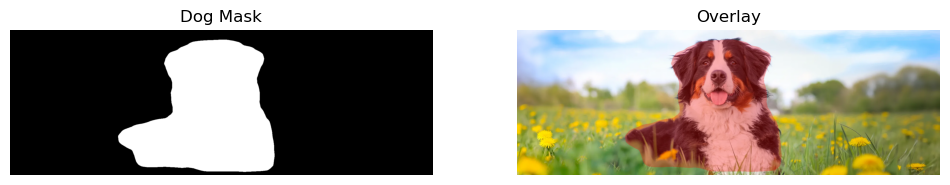

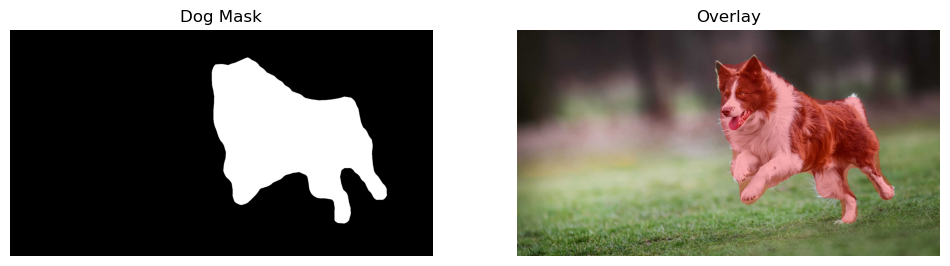

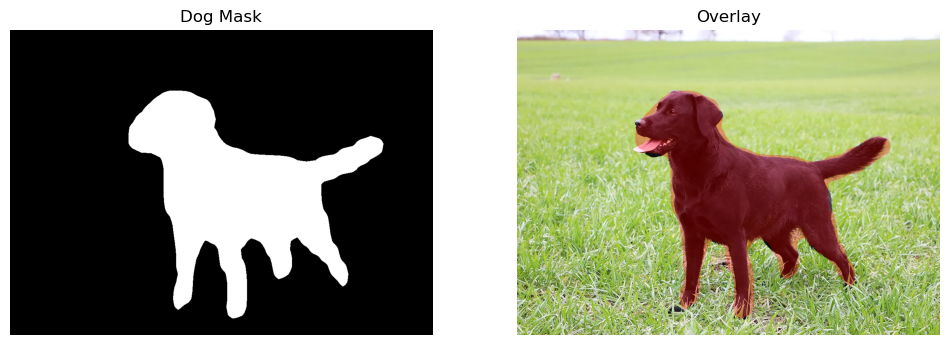

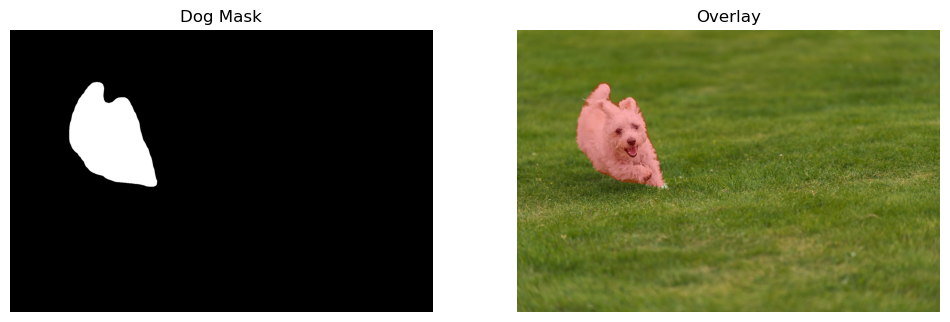

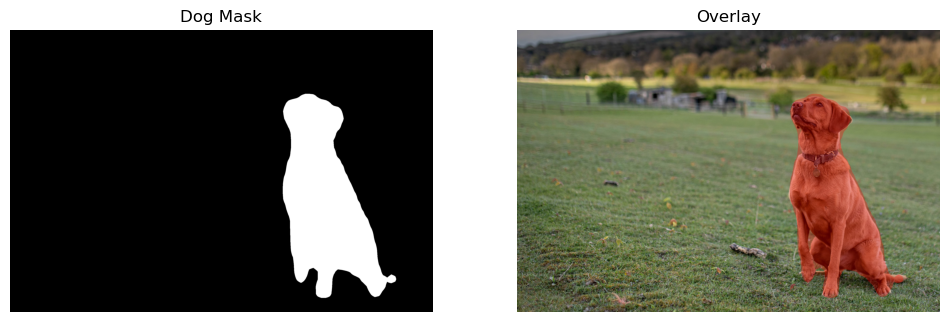

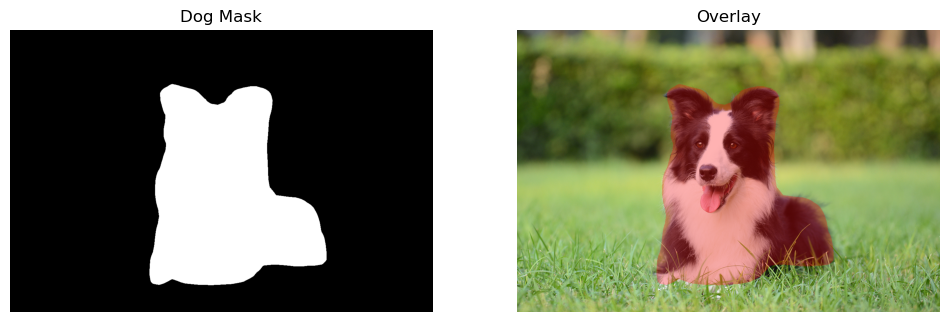

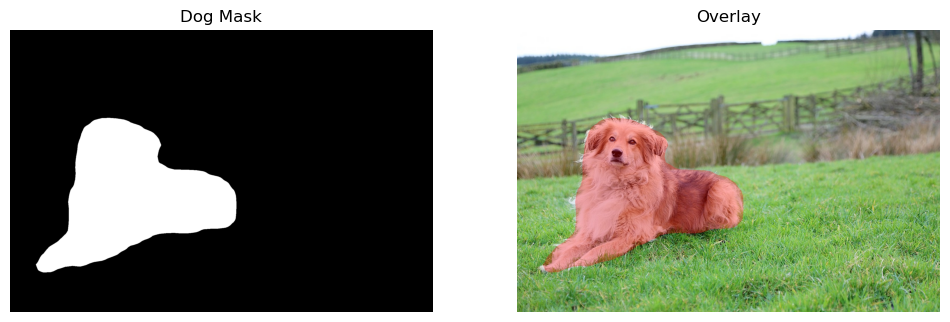

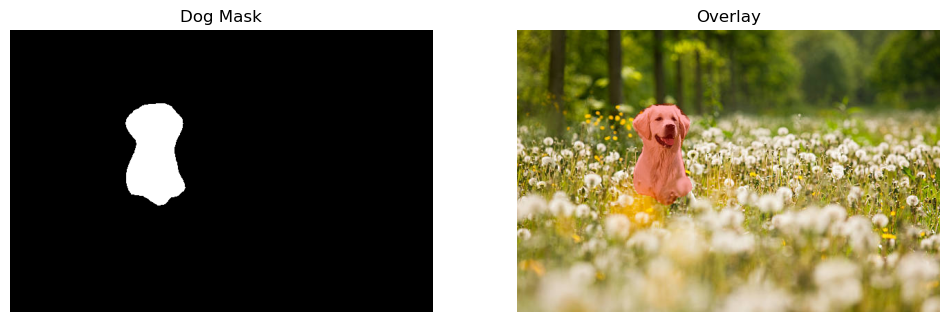

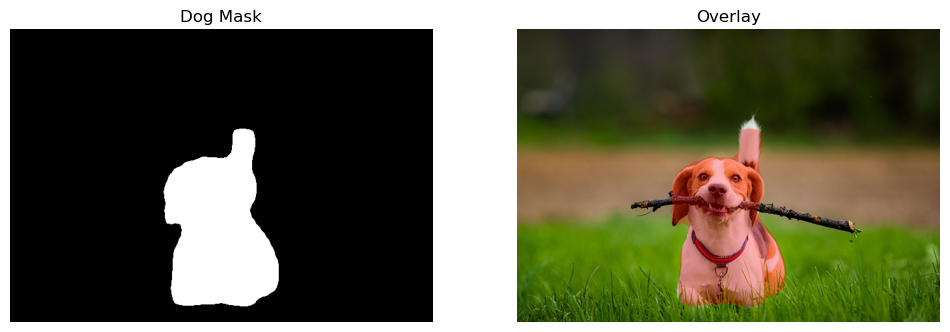

In [23]:
imagePaths = glob.glob("Img/*.jpg")
for imgPath in imagePaths:
        detectDogInFieldTorch(imgPath)